In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-12-30 11:53:21.318902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 11:53:21.675057: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
ReadList = ["Mass", "evt_trig", "fourjetmasstev",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [3]:
def add_more_cols(DF):
    DF["Truth"] = (DF["Mass"] > 0).astype(int)

In [4]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    if Mass == 0:
        TrainingRows = 100000*12
        TestingRows = 50000*12
        File = "ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root"
        
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1]
    DF = DF.sample(frac = 1).reset_index(drop=True)
    
    add_more_cols(DF)
    
    #TrainingRows = int(len(DF.index)*0.8)
    #TestingRows = int(len(DF.index)*0.2)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [5]:
Masses = [0, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

SanityCheckPlots = True

In [6]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root


Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root




Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Memory used: 0.8255081176757812GB


In [7]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
0,0,1,1.791173,1.196758,0.362580,0.956281,0.191806,0.727604,0.425834,2.790367,2.496327,2.283513,0.984000,1.911149,1.816006,0
1,0,1,1.634654,1.359910,0.131829,0.684277,0.194869,0.526096,0.184059,3.190170,1.083758,2.662557,0.830993,2.624601,0.607809,0
2,0,1,1.763555,1.086243,0.558665,0.976658,0.439170,0.529538,0.448729,2.959751,3.042847,3.788466,1.802064,2.353030,1.539801,0
3,0,1,1.439399,1.130558,0.224838,0.590616,0.147167,0.452695,0.415699,3.547585,1.995459,2.278467,0.921280,2.629925,1.651895,0
4,0,1,1.438587,1.057126,0.097065,0.770625,0.215552,0.537846,0.157486,3.121512,0.754074,3.433102,1.086253,2.991087,0.488153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,3000,1,8.266860,4.446258,2.477412,4.339688,2.639858,3.098146,2.683399,2.423740,2.146109,2.391089,2.192687,3.130073,1.770460,1
2399996,3000,1,7.639807,3.852322,3.659144,3.370282,2.130726,2.786189,2.556230,3.355668,2.930811,1.952980,1.621434,1.941218,1.789580,1
2399997,3000,1,6.062496,3.035354,2.543950,2.763246,2.523275,2.382293,1.203716,2.422481,3.167595,2.301873,2.895614,1.789810,1.344980,1
2399998,3000,1,5.929816,2.946473,2.587948,2.858874,2.369625,1.908876,1.549844,3.017545,2.844689,2.779084,2.326010,1.592087,1.132727,1


In [8]:
TrainingDF.dtypes

Mass                int32
evt_trig            int32
fourjetmasstev    float64
P1high_MTeV       float64
P1low_MTeV        float64
P2high_MTeV       float64
P2low_MTeV        float64
P3high_MTeV       float64
P3low_MTeV        float64
P1high_dR         float64
P1low_dR          float64
P2high_dR         float64
P2low_dR          float64
P3high_dR         float64
P3low_dR          float64
Truth               int64
dtype: object

In [9]:
TrainingDF = TrainingDF.sample(frac = 1)
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
356240,0,1,1.390856,0.909046,0.229952,0.763405,0.400782,0.519317,0.251531,2.622003,1.233055,2.877411,1.942772,1.892691,0.942001,0
1635745,900,1,1.560242,0.868971,0.509721,0.862941,0.374338,0.644932,0.357753,3.100456,2.409763,3.349564,1.665316,1.585087,1.599458,1
1797989,1000,1,1.872938,1.234525,0.449411,0.973826,0.686047,0.557396,0.259582,2.962524,2.900378,3.200257,2.861969,1.362062,0.693916,1
1587975,800,1,1.885264,1.060097,0.767680,0.930183,0.738088,0.536327,0.401720,3.206597,3.117287,2.180285,2.462630,1.184859,1.021765,1
49573,0,1,2.331228,1.928099,0.211044,0.861428,0.155588,0.713752,0.651474,3.322447,1.255914,2.335057,0.430881,3.195769,1.579198,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131501,0,1,1.830778,1.462997,0.321296,0.701942,0.585965,0.519062,0.132669,3.016136,2.476613,2.113401,2.574226,1.472337,0.442259,0
713402,0,1,3.143337,1.887764,0.990231,1.556155,1.250137,1.141749,0.276175,2.780047,2.291066,2.451520,2.609683,1.692721,0.434622,0
796721,0,1,1.772267,1.539209,0.164824,0.573396,0.287342,0.557731,0.176687,3.101342,1.814894,2.610457,1.249217,2.325272,0.646847,0
2320056,3000,1,7.772918,4.617327,1.916575,3.375940,3.354589,2.702305,2.439193,2.766520,2.020117,2.488635,3.147896,1.830627,1.428420,1


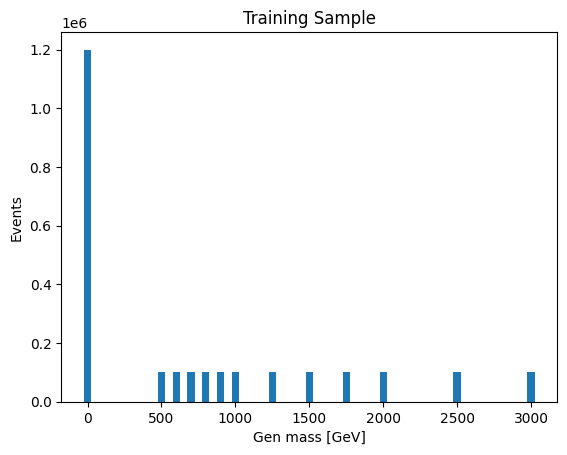

In [10]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

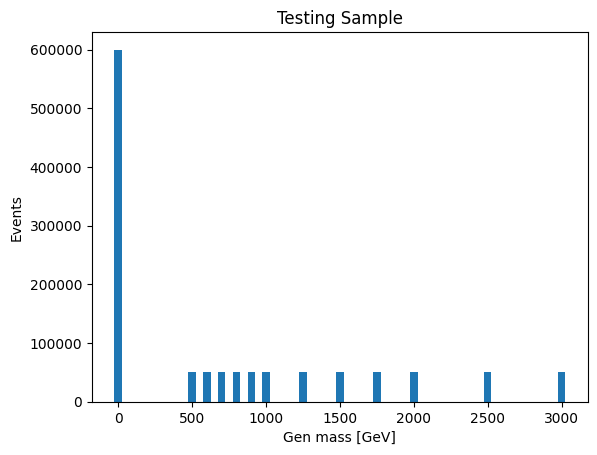

In [11]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

/tmp/ipykernel_2188/1985655967.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


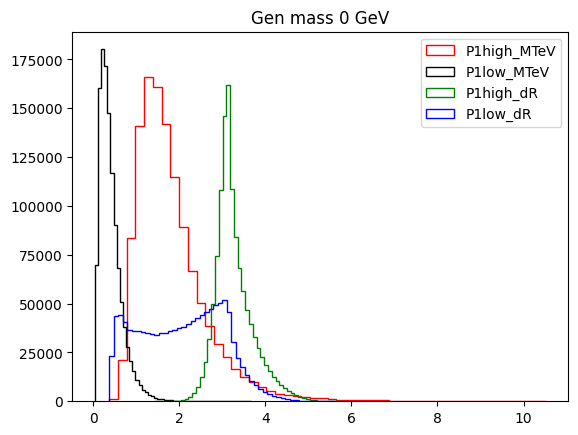

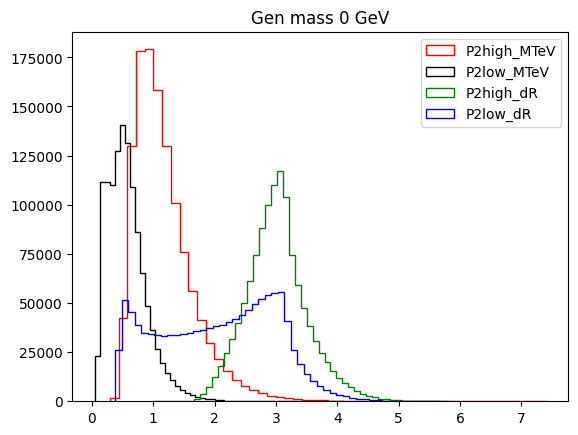

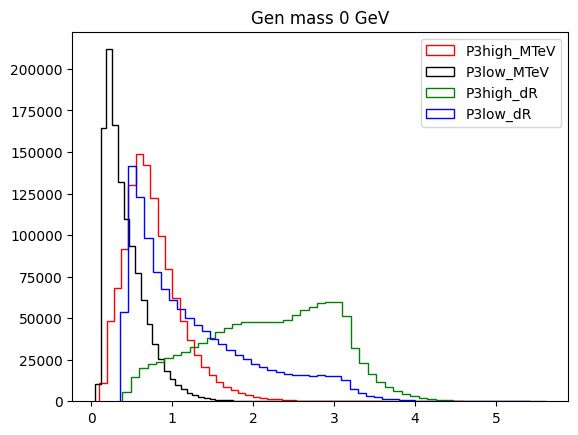

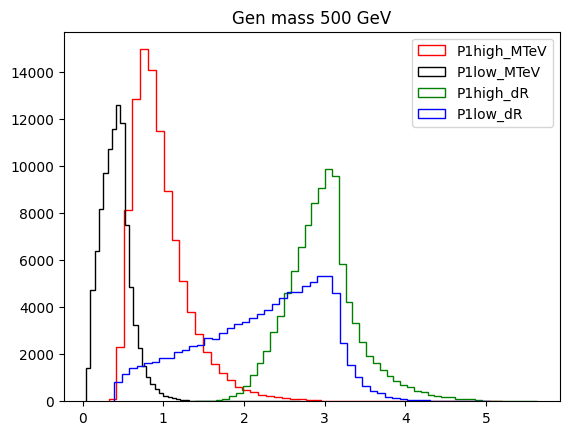

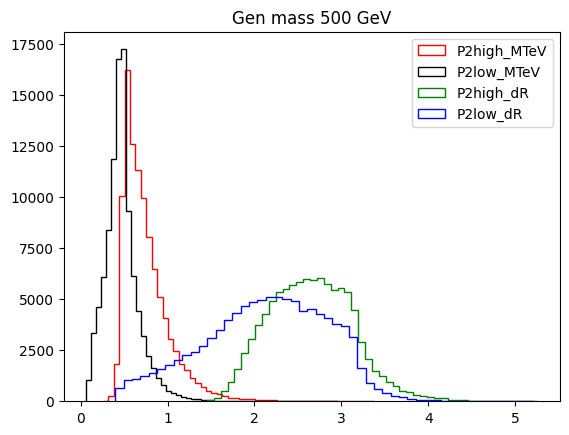

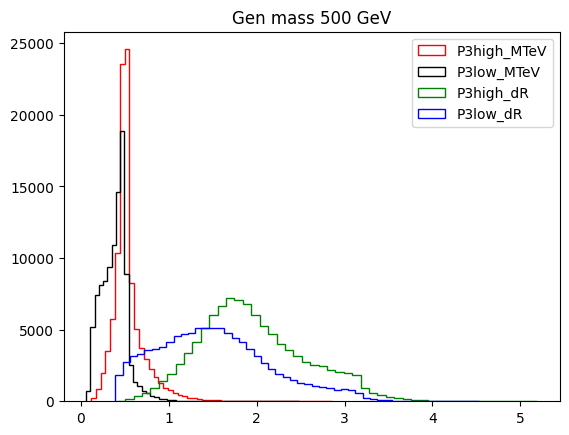

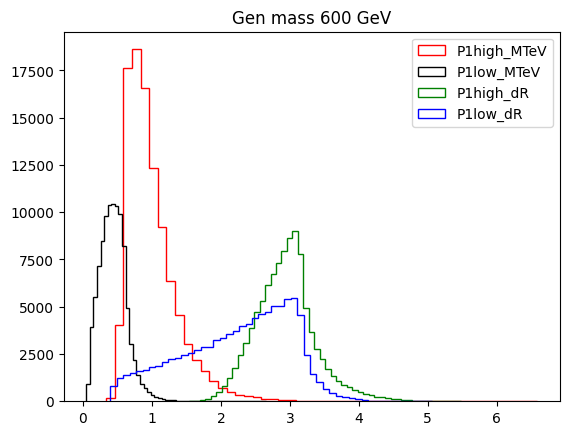

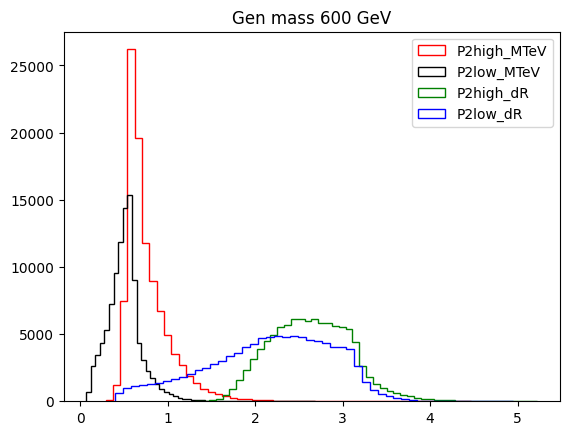

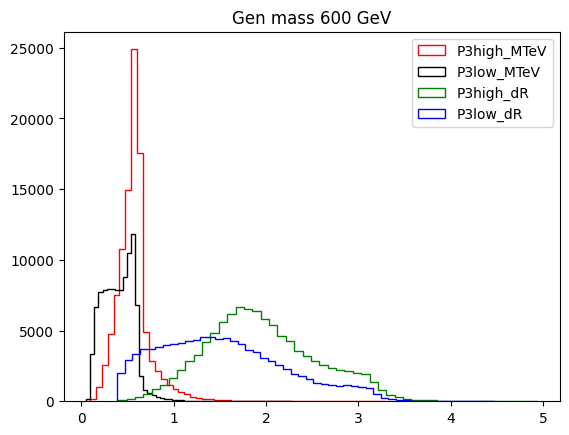

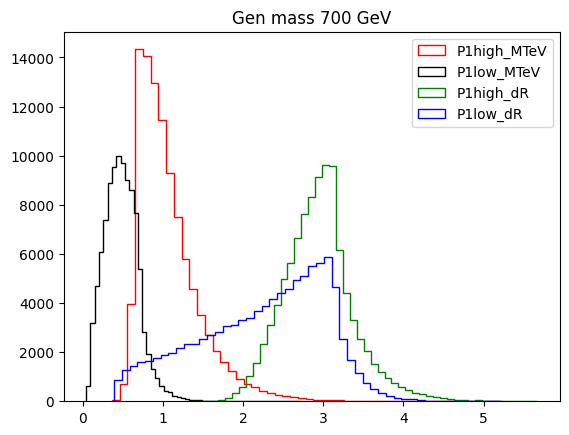

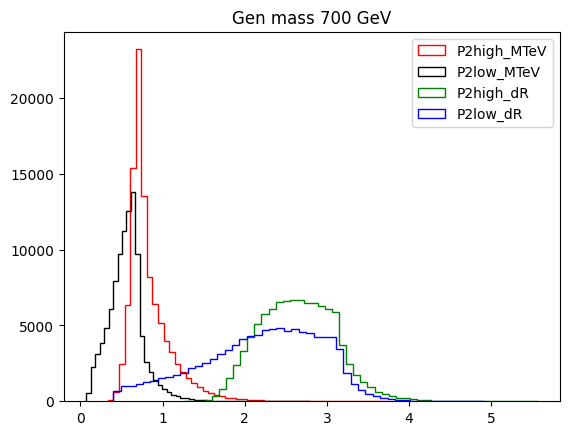

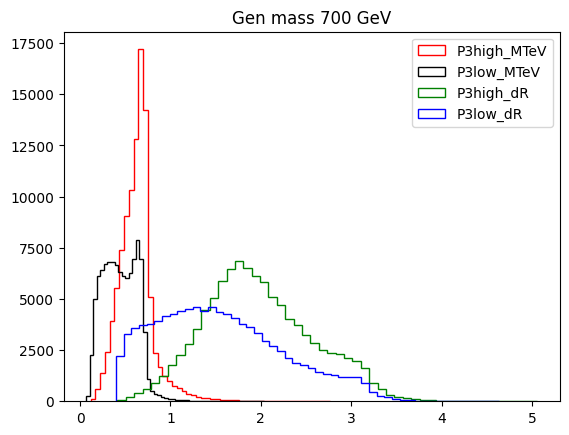

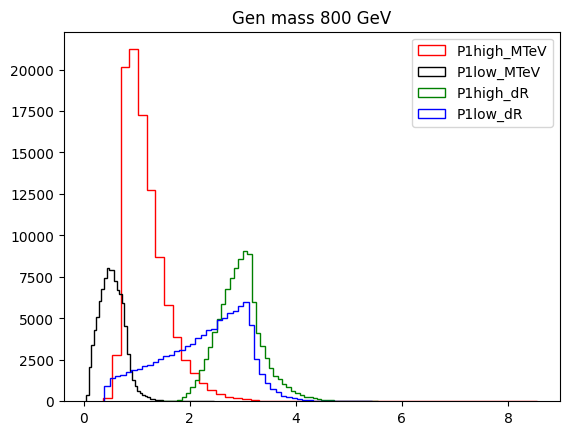

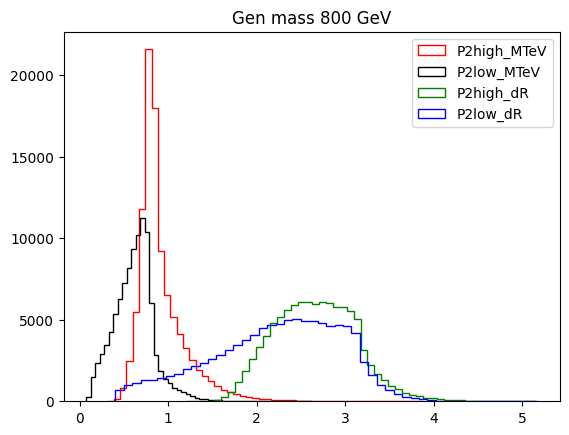

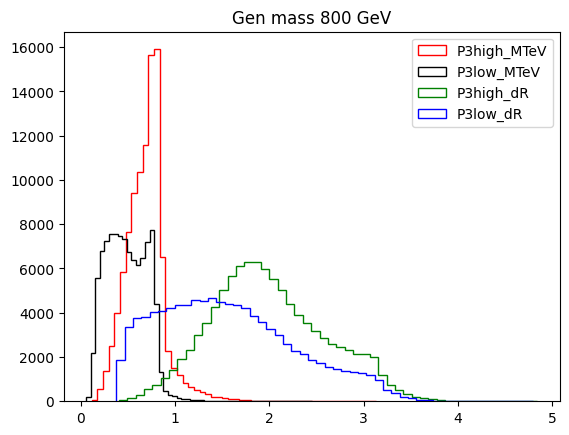

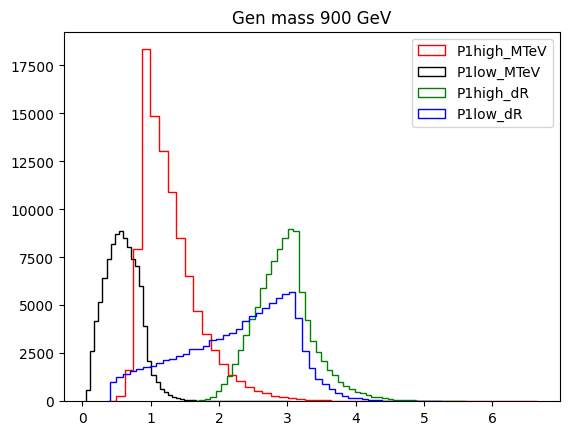

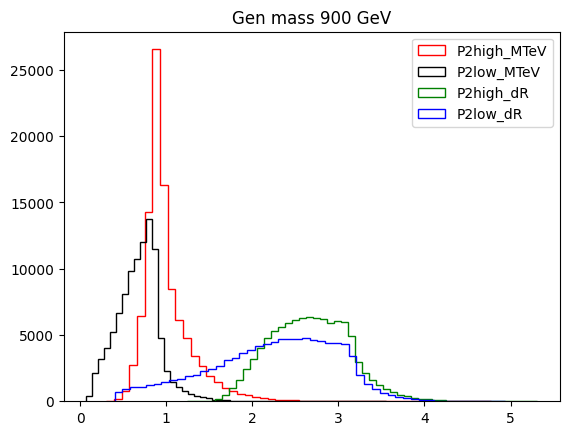

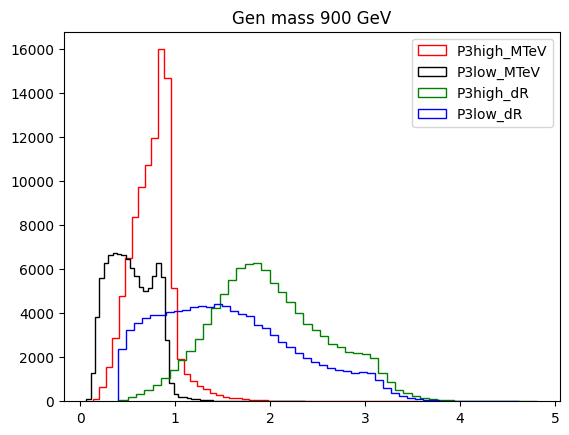

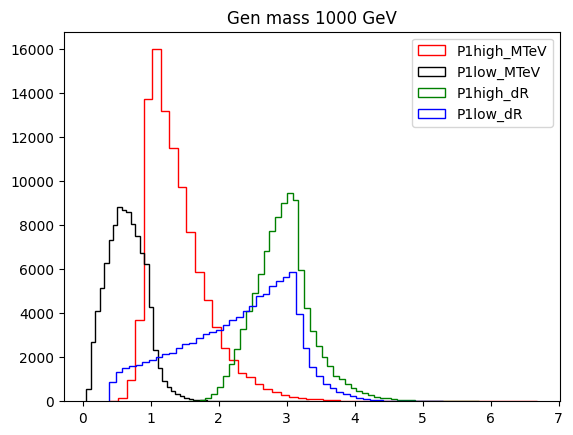

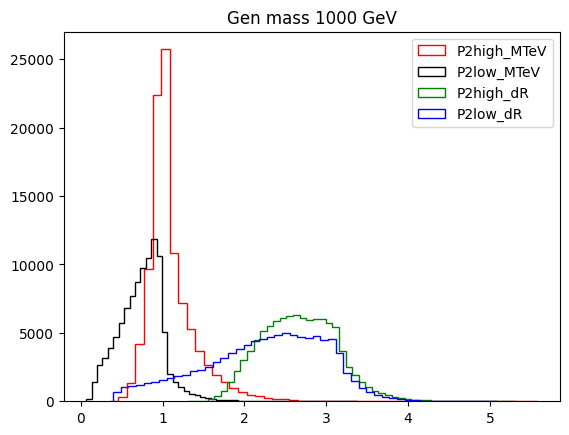

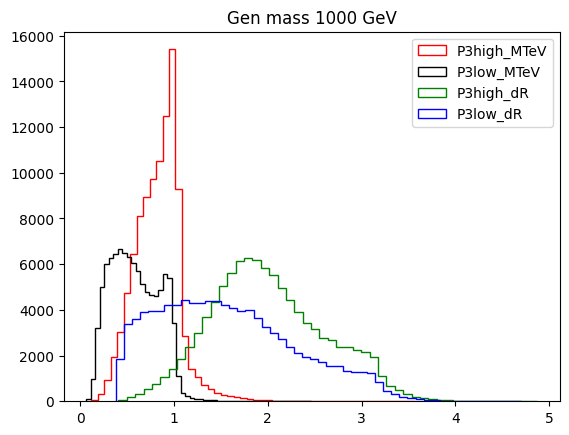

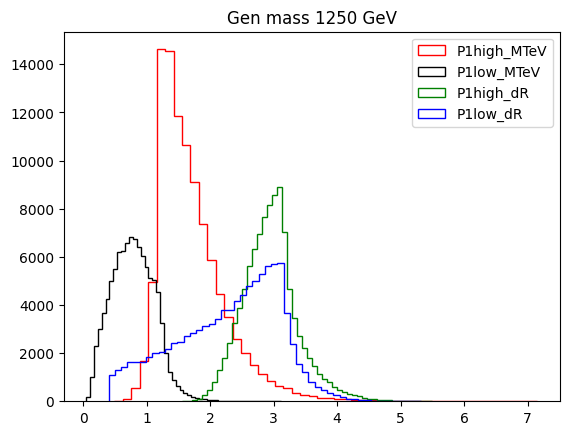

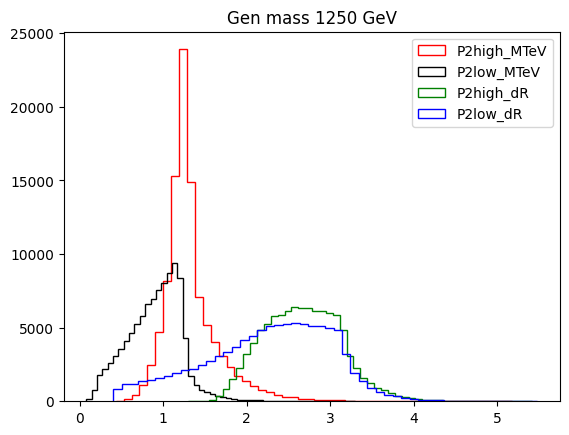

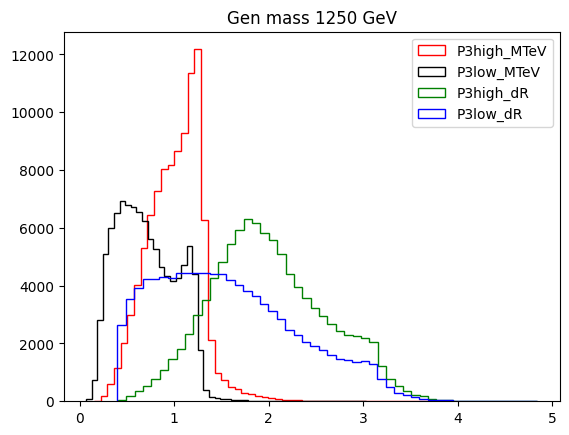

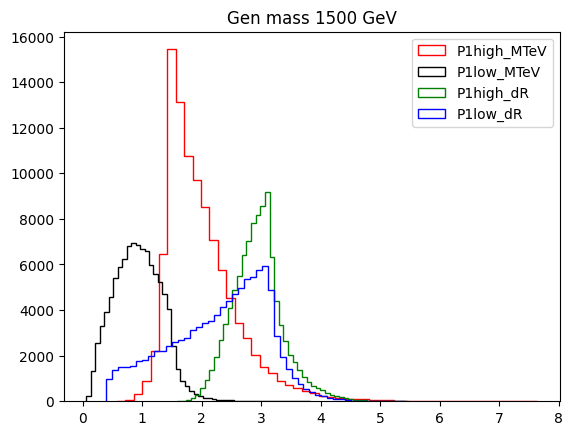

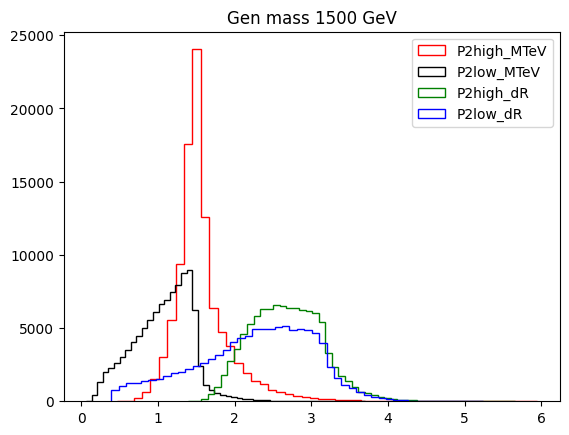

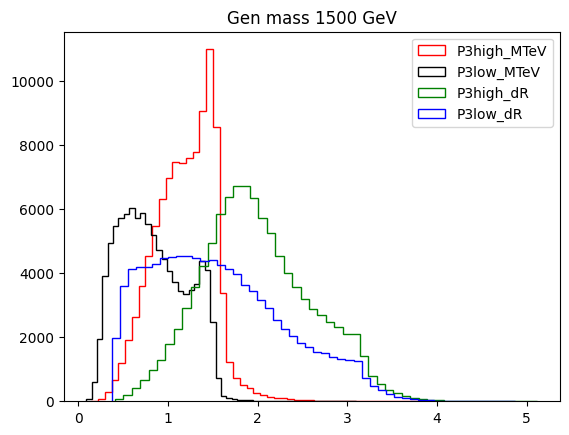

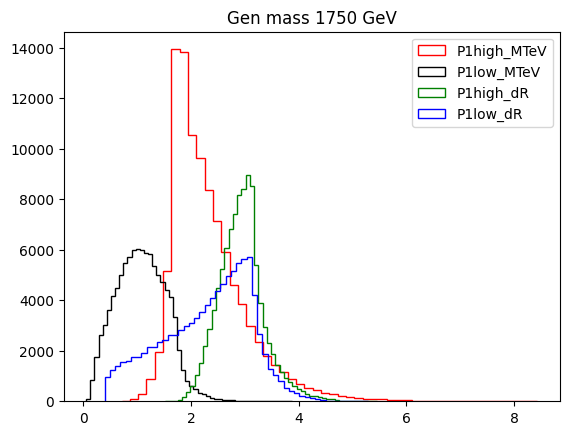

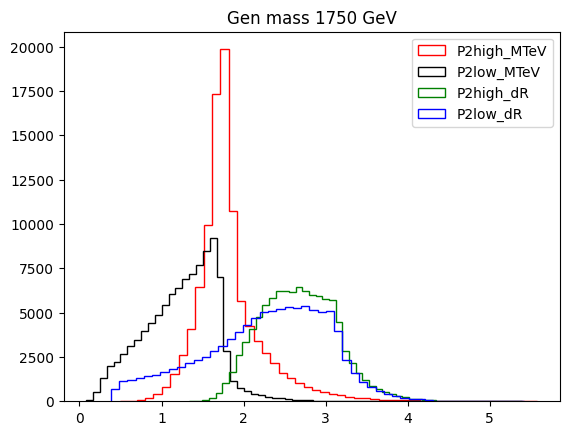

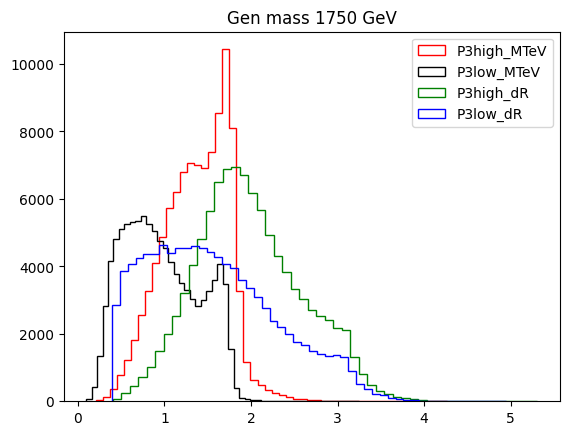

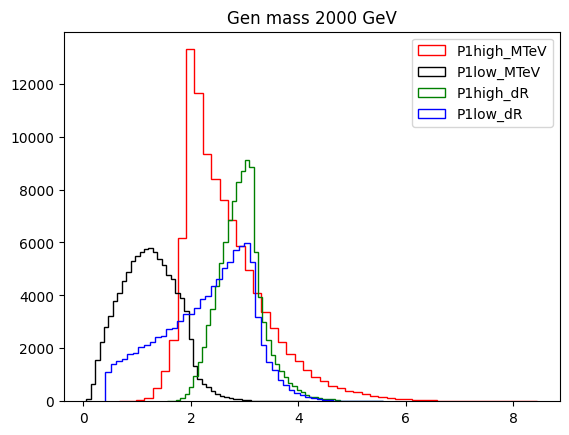

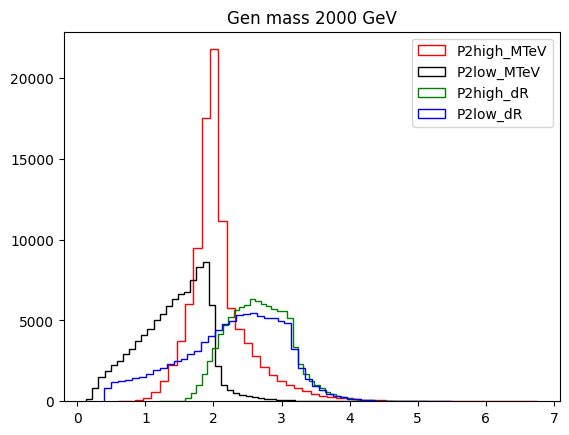

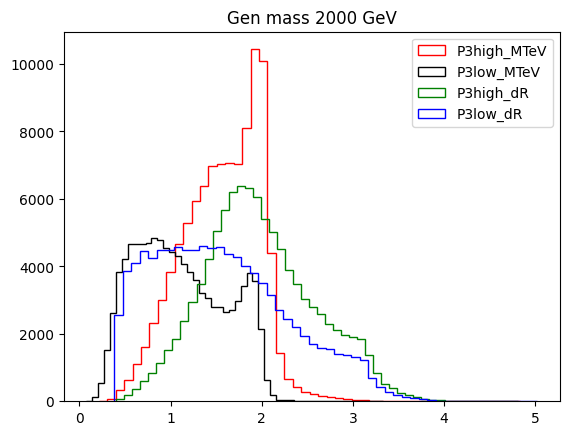

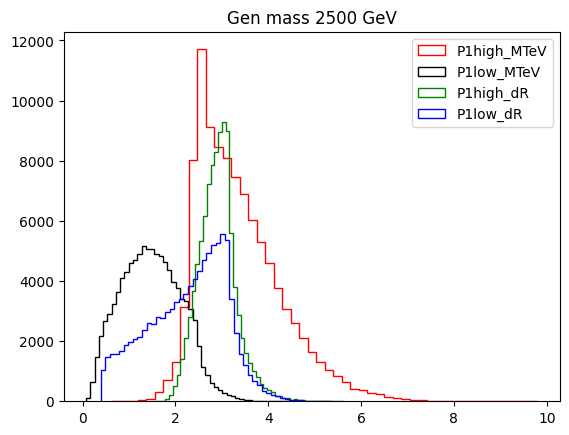

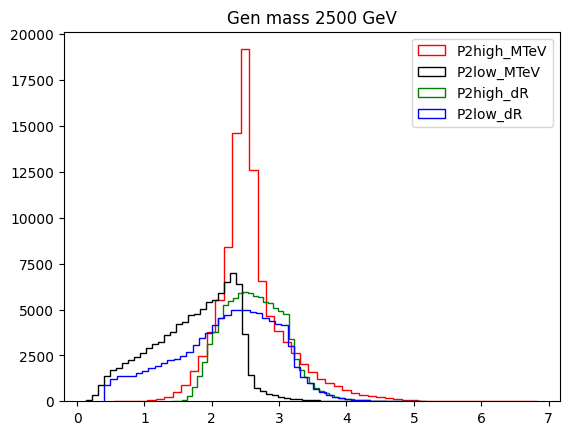

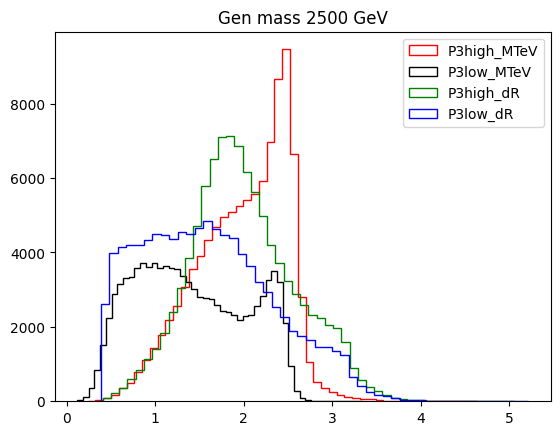

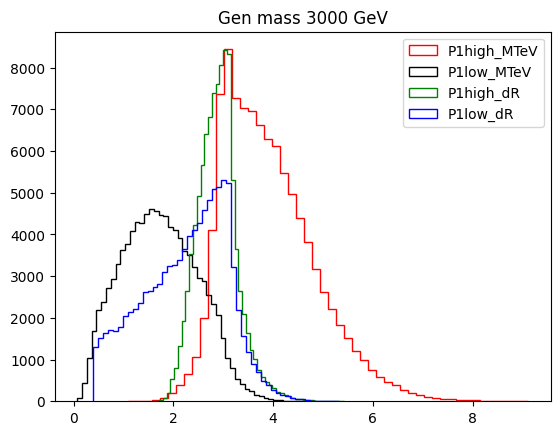

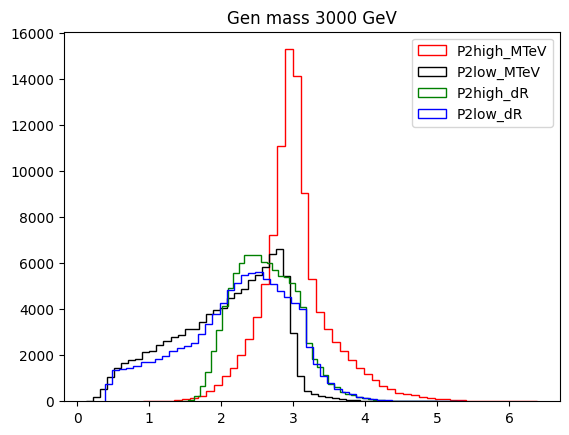

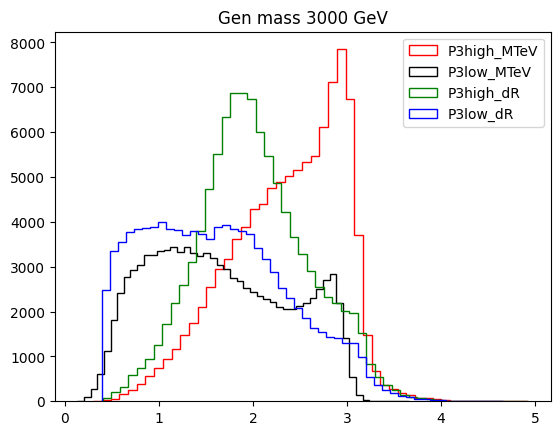

In [12]:
if SanityCheckPlots:
    for Mass in Masses:
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [13]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [14]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(2400000, 15)
(2400000,)
(1200000, 15)


In [15]:
NotebookName = "SigBG_CNN_more"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [16]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [17]:
def model_CNN_more():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(32, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNNMore"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [18]:
#Model = model_CNN()
Model = model_CNN_more()

2023-12-30 11:53:44.029753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-30 11:53:44.991568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [19]:
Model.summary()

Model: "ModelCNNMore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 32)          224       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 model_out (Dense)           (None, 2)                 18        
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-traina

In [20]:
import pydot
import graphviz
tf.keras.utils.plot_model(Model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 100, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/100


2023-12-30 11:53:47.501805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


384/384 [==============================] - 5s 6ms/step - loss: 0.4125 - accuracy: 0.8113 - val_loss: 0.3619 - val_accuracy: 0.8409
Epoch 2/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3604 - accuracy: 0.8413 - val_loss: 0.3571 - val_accuracy: 0.8430
Epoch 3/100
384/384 [==============================] - 2s 6ms/step - loss: 0.3575 - accuracy: 0.8423 - val_loss: 0.3554 - val_accuracy: 0.8439
Epoch 4/100
384/384 [==============================] - 2s 6ms/step - loss: 0.3562 - accuracy: 0.8429 - val_loss: 0.3543 - val_accuracy: 0.8438
Epoch 5/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3550 - accuracy: 0.8436 - val_loss: 0.3537 - val_accuracy: 0.8445
Epoch 6/100
384/384 [==============================] - 2s 6ms/step - loss: 0.3542 - accuracy: 0.8438 - val_loss: 0.3545 - val_accuracy: 0.8439
Epoch 7/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3540 - accuracy: 0.8438 - val_loss: 0.3557 - val_accuracy: 0.8425
Epoch 8/100

384/384 [==============================] - 2s 6ms/step - loss: 0.3473 - accuracy: 0.8468 - val_loss: 0.3473 - val_accuracy: 0.8468
Epoch 59/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3474 - accuracy: 0.8467 - val_loss: 0.3463 - val_accuracy: 0.8475
Epoch 60/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3470 - accuracy: 0.8469 - val_loss: 0.3462 - val_accuracy: 0.8477
Epoch 61/100
384/384 [==============================] - 2s 6ms/step - loss: 0.3469 - accuracy: 0.8469 - val_loss: 0.3458 - val_accuracy: 0.8478
Epoch 62/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3470 - accuracy: 0.8470 - val_loss: 0.3455 - val_accuracy: 0.8479
Epoch 63/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3468 - accuracy: 0.8471 - val_loss: 0.3464 - val_accuracy: 0.8474
Epoch 64/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3469 - accuracy: 0.8470 - val_loss: 0.3461 - val_accuracy: 0.8477
Epoch

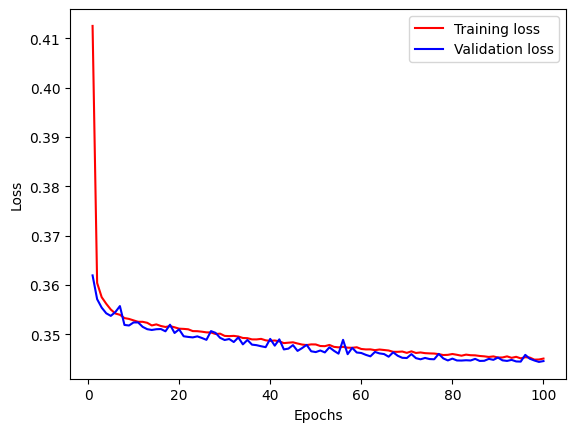

In [22]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [23]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

240/240 [==============================] - 1s 2ms/step


In [24]:
print(TestingOutputs.shape)
print(TestingOutputs[0]) #ML raw output is the probability of 2 sparse categories

(1200000, 2)
[0.90554553 0.09445443]


In [25]:
TestingDF["PredSigProb"] = TestingOutputs[:,1].tolist()
TestingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth,PredSigProb
0,0,1,3.706236,2.180786,0.634183,2.019327,0.647193,1.886085,0.738130,3.221211,2.331554,3.315750,3.196879,3.575433,1.496448,0,0.094454
1,0,1,1.547186,1.146127,0.171929,0.676868,0.405182,0.646140,0.175037,2.921476,1.250726,3.011113,1.692566,2.803673,0.485559,0,0.047071
2,0,1,1.862537,1.215881,0.214144,0.984535,0.174739,0.850670,0.495262,3.531157,0.936011,2.927491,1.103475,3.525085,2.028774,0,0.084228
3,0,1,1.677131,1.057395,0.588525,0.918035,0.607129,0.306511,0.251283,3.370870,3.052346,3.144272,3.213155,1.019152,0.508597,0,0.190982
4,0,1,4.060864,3.429879,0.089479,1.538873,0.741975,1.039059,0.860071,3.589878,0.426644,2.793912,2.344482,2.380759,2.258969,0,0.029675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,3000,1,8.719409,5.334855,2.017550,5.136096,0.452865,3.043523,2.823847,2.906342,2.175842,2.799467,0.415512,1.765174,2.678097,1,0.996451
1199996,3000,1,5.873986,3.340021,1.128584,2.916557,0.951599,2.722017,2.347826,2.506305,1.320771,2.330024,1.502989,2.575782,3.305705,1,0.994914
1199997,3000,1,5.620216,3.630930,1.657588,2.554114,1.975324,2.018247,1.115219,2.884457,2.361005,2.249414,2.359605,1.758989,1.047516,1,0.994201
1199998,3000,1,7.126898,5.108077,1.394737,2.978586,2.517814,2.711173,0.580941,3.079431,2.350732,2.139035,3.031536,1.629645,0.493378,1,0.989086


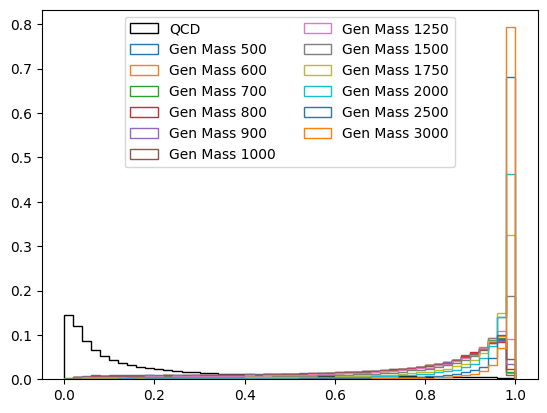

In [26]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")

plt.savefig(ResultsDir + "Pred_Signal_Prob.png")

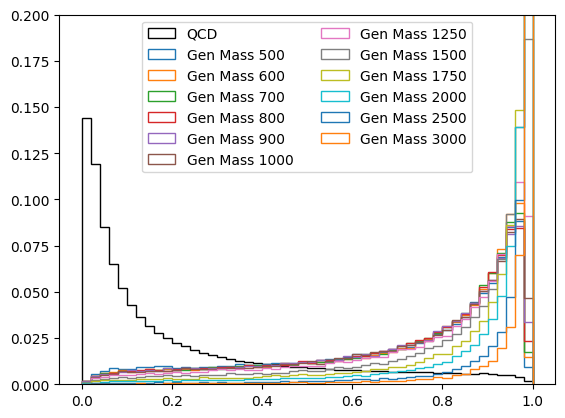

In [27]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")
    plt.ylim(0, 0.2)
    
plt.savefig(ResultsDir + "Pred_Signal_Prob_Zoom.png")

fpr_in_use ['0.0100', '0.0500', '0.1000']
Thresholds ['0.9426', '0.8016', '0.6509']
Efficiencies ['0.40', '0.66', '0.78']


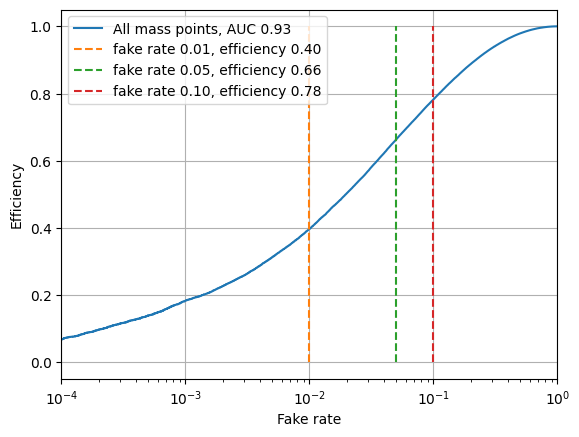

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TestingDF["Truth"].to_numpy(),
                                 TestingDF["PredSigProb"].to_numpy())
roc_auc = auc(fpr, tpr)

#plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
plt.plot(fpr, tpr, label = "All mass points, AUC %.2f" % roc_auc)
plt.xlabel("Fake rate")
plt.ylabel("Efficiency")
plt.xscale("log")
plt.xlim(0.0001, 1)
plt.grid()

FakeRates = [0.01, 0.05, 0.1]
fpr_in_use = []
Thresholds = []
for FakeRate in FakeRates:
    Index = (np.abs(fpr - FakeRate)).argmin()
    fpr_in_use.append(fpr[Index])
    Thresholds.append(thresholds[Index])
    
    plt.plot([FakeRate, FakeRate], [0, 1], linestyle="--",
             label = "fake rate %.2f, efficiency %.2f" % (FakeRate, tpr[Index]))
    
plt.legend()
plt.savefig(ResultsDir + "ROC_all_logX.png")

#print(fpr)
#print(thresholds)
print("fpr_in_use", ["%.4f" % i for i in fpr_in_use])
print("Thresholds", ["%.4f" % i for i in Thresholds])

0.9425541758537292 0.009998333333333333
0.8015574216842651 0.04999833333333333
0.6509008407592773 0.09999833333333333


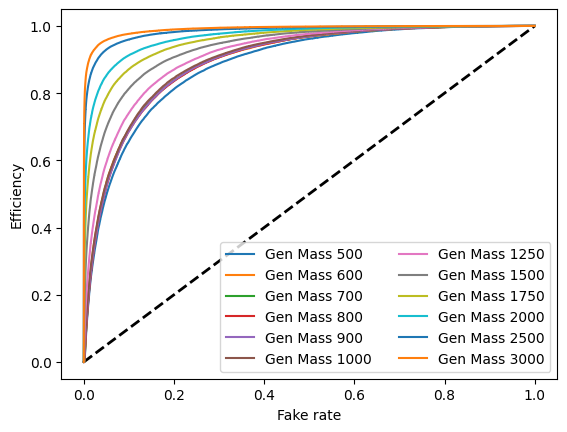

In [29]:
TestingDF_QCD = TestingDF.loc[TestingDF["Mass"] == 0]

for Mass in Masses:
    if Mass == 0:
        plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
        for Threshold in Thresholds:
            TestingDF_QCD_pass = TestingDF_QCD.loc[TestingDF_QCD["PredSigProb"] > Threshold]
            print(Threshold, float(len(TestingDF_QCD_pass.index)) / len(TestingDF_QCD.index))
    else:
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        TestingDF_temp = pd.concat([TestingDF_temp, TestingDF_QCD], ignore_index=True)
        fpr, tpr, thresholds = roc_curve(TestingDF_temp["Truth"].to_numpy(),
                                         TestingDF_temp["PredSigProb"].to_numpy())

        plt.plot(fpr, tpr, label = "Gen Mass " + str(Mass))
        plt.xlabel("Fake rate")
        plt.ylabel("Efficiency")
        plt.legend(ncol=2, loc="lower right")
        
plt.savefig(ResultsDir + "ROC.png")

In [30]:
TestingDF["PredTight"] = (TestingDF["PredSigProb"] > Thresholds[0]).astype(int)
TestingDF["PredMedium"] = (TestingDF["PredSigProb"] > Thresholds[1]).astype(int)
TestingDF["PredLoose"] = (TestingDF["PredSigProb"] > Thresholds[2]).astype(int)

AccPredTight = []
AccPredMedium = []
AccPredLoose = []

for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    
    TestingDF_PredTight = TestingDF_temp.loc[TestingDF_temp["PredTight"]==TestingDF_temp["Truth"]]
    TestingDF_PredMedium = TestingDF_temp.loc[TestingDF_temp["PredMedium"]==TestingDF_temp["Truth"]]
    TestingDF_PredLoose = TestingDF_temp.loc[TestingDF_temp["PredLoose"]==TestingDF_temp["Truth"]]
    
    AccPredTight.append(float(len(TestingDF_PredTight.index))/len(TestingDF_temp.index))
    AccPredMedium.append(float(len(TestingDF_PredMedium.index))/len(TestingDF_temp.index))
    AccPredLoose.append(float(len(TestingDF_PredLoose.index))/len(TestingDF_temp.index))

In [31]:
AccPredTightAvg = "Avg %.2f" % float(sum(AccPredTight)/len(AccPredTight))
AccPredMediumAvg = "Avg %.2f" % float(sum(AccPredMedium)/len(AccPredMedium))
AccPredLooseAvg = "Avg %.2f" % float(sum(AccPredLoose)/len(AccPredLoose))

print(["%.2f" % i for i in AccPredTight], AccPredTightAvg)
print(["%.2f" % i for i in AccPredMedium], AccPredMediumAvg)
print(["%.2f" % i for i in AccPredLoose], AccPredLooseAvg)

['0.99', '0.17', '0.19', '0.19', '0.18', '0.19', '0.21', '0.28', '0.41', '0.55', '0.67', '0.82', '0.89'] Avg 0.44
['0.95', '0.50', '0.53', '0.53', '0.52', '0.52', '0.53', '0.59', '0.70', '0.79', '0.85', '0.93', '0.96'] Avg 0.68
['0.90', '0.66', '0.69', '0.69', '0.69', '0.69', '0.69', '0.74', '0.81', '0.87', '0.91', '0.96', '0.98'] Avg 0.79


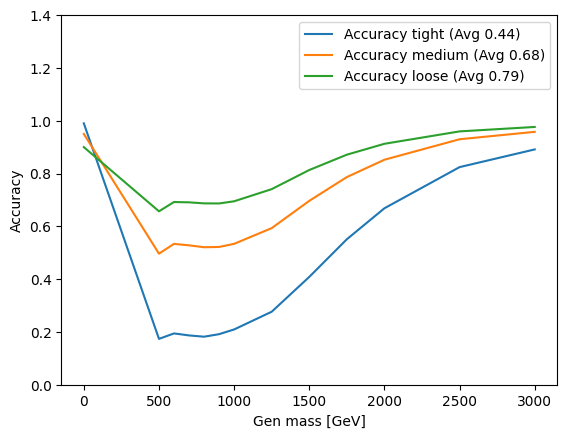

In [32]:
plt.plot(Masses, AccPredTight, label = "Accuracy tight (" + AccPredTightAvg + ")")
plt.plot(Masses, AccPredMedium, label = "Accuracy medium (" + AccPredMediumAvg + ")")
plt.plot(Masses, AccPredLoose, label = "Accuracy loose (" + AccPredLooseAvg + ")")

plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")